# 2st Assignment: Social Media Sanctions and Misinformation Sharing 
> Markella Englezou, 8210039 <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> t8210039@aueb.gr

*There has been a lot of discussions on politics and sanctions in social media. Specifically, people with conservative beliefs argue that they are more likely to be sanctioned on social media than those with more liberal beliefs.*

*If this happens, however, that may not necessarily be the result of different policies on behalf of the social media companies. It may simply be that people with conservative beliefs post online more questionable content, and so they are more likely to be sanctioned even with a completely neutral sanction policy.*

*In a [recent analysis in Nature](https://www.nature.com/articles/s41586-024-07942-8), Mohshen Moshel et al. investigated whether social media sanctions are politically biased or they are the result of differences in misinformation sharing between people of different political beliefs. The authors argue that that media sanctions are not politically biased. Social media users with conservative political beliefs are more likely to post questionable or misinformation material, and so they are more likely to be sanctioned. In this assignment, you will follow through some of Moshel et al.'s research.*

*You will use their data, available at [mosleh_et_al_data.csv](mosleh_et_al_data.csv).*

* Importing all necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import textwrap

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.decomposition import PCA

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats.mstats import winsorize

from math import pi

* Reading the dataset.

In [2]:
df = pd.read_csv('mosleh_et_al_data.csv')

* Initializing the StandardScaler.

In [3]:
scaler = StandardScaler()

# Twitter Suspensions after the 2020 Election

*Show, using crosstabulation, that accounts that shared `#Trump2020` during the election were about 4.4 times more likely to be subsequently suspended than the accounts that shared `#VoteBidenHarris2020` (relevant columns: `politics_hashtag` and `suspended`). Then perform a $\chi^2$ test on the contingency table and explain the results.*

* Creating a crosstabulation table for the relevant columns.

In [4]:
crosstab = pd.crosstab(df['politics_hashtag'], df['suspended'])

* Calculating the likelihood ratios for '#Trump2020' vs '#VoteBidenHarris2020'.
* Adjusting for the coding where #Trump2020 is 1 and #VoteBidenHarris2020 is 0.
* Printing the suspension rate.

In [5]:
suspended_trump = crosstab.loc[1, 1] / crosstab.loc[1].sum()
suspended_biden = crosstab.loc[0, 1] / crosstab.loc[0].sum()
print(f"Suspended accounts are {suspended_trump / suspended_biden:.1f} times more likely for #Trump2020")

Suspended accounts are 4.4 times more likely for #Trump2020


* Performing the Chi-squared test.
* Printing the results.

In [6]:
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"\nChi-squared Test Results:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: \n{expected}")


Chi-squared Test Results:
Chi-squared statistic: 485.46706126582285
p-value: 1.3808204811294585e-107
Degrees of freedom: 1
Expected frequencies: 
[[3954.60111111  540.39888889]
 [3963.39888889  541.60111111]]


* From the large Chi-Squared statistic and the really small p-value (< 0.05) it is derived that there is a strong and statistically significant association between the hashtag and the account suspension.
* Also, the observed data and the frequencies that would be expected under the null hypothesis are substantially different. This shows that the hashtag and account suspension are not independent and are related.

# Distributions of Relative Frequency of Low Quality

*Plot the distributions of low-quality sharing as determined by eight professional fact-checkers (column `lowqual_pr2019_fc`), grouped by `politics_hashtag`. The $x$-axis should be standardized using z-scores.*

* Standardizing the 'lowqual_pr2019_fc' column.
* Checking the variances.
* Plotting the distributions.

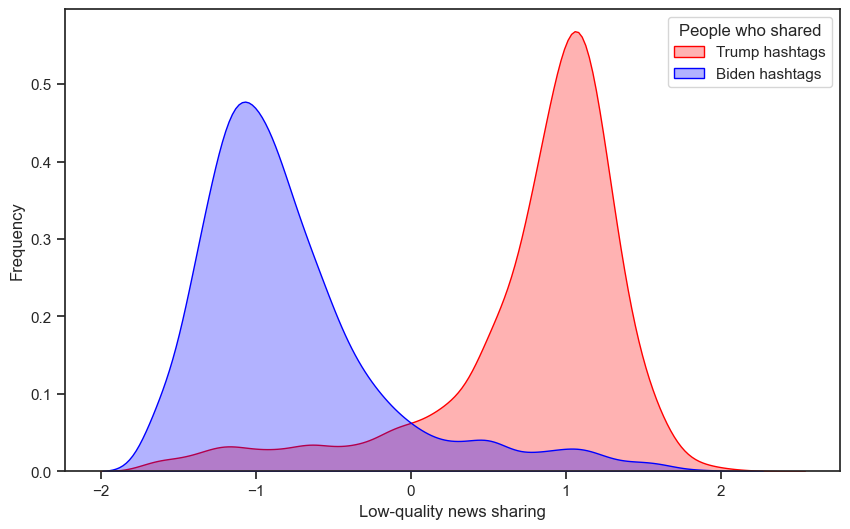

In [7]:
# Standardize the 'lowqual_pr2019_fc' column
df['lowqual_pr2019_fc_st'] = scaler.fit_transform(df[['lowqual_pr2019_fc']])

# Set the plot style
sns.set(style="ticks")

# Create a new column for group labels
df['politics_group'] = df['politics_hashtag'].map({1: 'Trump hashtags', 0: 'Biden hashtags'})

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the distributions
sns.kdeplot(data=df, x='lowqual_pr2019_fc_st', hue='politics_group', fill=True, alpha=0.3, common_norm=True, palette={'Trump hashtags': 'red', 'Biden hashtags': 'blue'})

# Add labels
plt.xlabel("Low-quality news sharing", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Display the legend
plt.legend(title="People who shared", labels=['Trump hashtags', 'Biden hashtags'])

# Show the plot
plt.show()


*Having done that, proceed to do the same with low-quality sharing as determined by crowdsourcing from 971 participants from the USA (column `lowqual_pr2019_crowd`).*

* Standardizing the 'lowqual_pr2019_crowd' column.
* Checking the variances.
* Plotting the distributions.

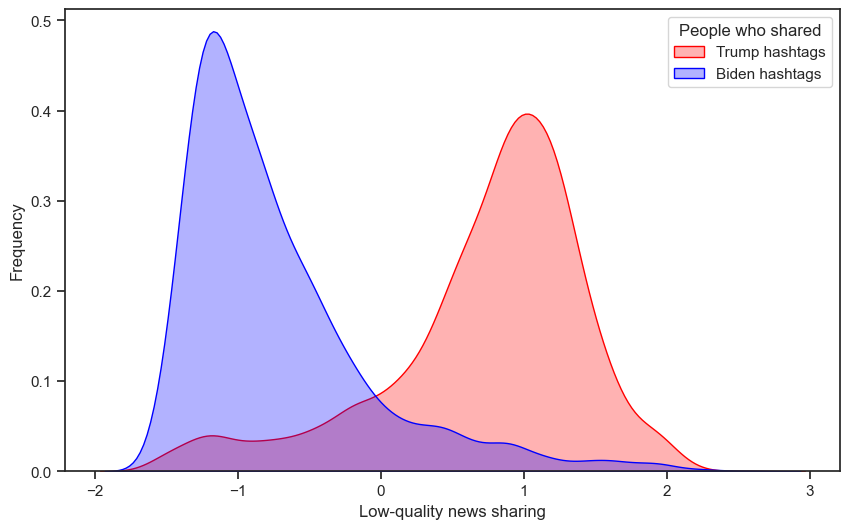

In [8]:
# Standardize the 'lowqual_pr2019_crowd' column
df['lowqual_pr2019_crowd_st'] = scaler.fit_transform(df[['lowqual_pr2019_crowd']])

# Set the plot style
sns.set(style="ticks")

# Create a new column for group labels
df['politics_group'] = df['politics_hashtag'].map({1: 'Trump hashtags', 0: 'Biden hashtags'})

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the distributions
sns.kdeplot(data=df, x='lowqual_pr2019_crowd_st', hue='politics_group', fill=True, alpha=0.3, common_norm=True, palette={'Trump hashtags': 'red', 'Biden hashtags': 'blue'})

# Add labels
plt.xlabel("Low-quality news sharing", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Display the legend
plt.legend(title="People who shared", labels=['Trump hashtags', 'Biden hashtags'])

# Show the plot
plt.show()

# Low-quality News Sharing on Twitter

*We will proceed to examine low-quality news sharing on Twitter on a more quantitave manner, using the t-test. In particular, we will use the t-test based on groups of users depending on their `politics_hashtag` and various assessments of low-quality news sharing. We will quantify the effect size of the t-test using Cohen's $d$ and Hedges' $g$.*

*Cohen's $d$ is defined as the difference between two means divided by a standard deviation for the data, i.e.:*

$$ d = \frac{\bar{x}_{1} - \bar{x}_{2}}{s} $$

*$s$, the pooled standard deviation for two independent samples is defined as:*

$$ s=\sqrt{\frac{(n_{1}-1)s_{1}^{2}+(n_{2}-1)s_{2}^{2}}{n_{1}+n_{2}-2}} $$

*where $n_1$, $n_2$ is the size of each sample and the variance of $s_1$ is defined as:*

$$ s_{1}^{2}=\frac{1}{n_{1}-1} \sum _{i=1}^{n_{1}}(x_{1,i}-{\bar {x}}_{1})^{2} $$

*with the variance of $s_2$ defined similarly. The values of Cohen's $d$ can be interpreted as follows:*

| Effect Size | $d$  |
|-------------|------|
| Very small  | 0.01 |
| Small	      | 0.20 |
| Medium	  | 0.50 |
| Large	      | 0.80 |
| Very large  | 1.20 |
| Huge        | 2.00 |

*Hedges' $g$ corrects Cohen's $d$ for bias in small sample sizes and is defined as:*

$$ 1 - \bigg(\frac{3}{4  (n_1 + n_2) - 9)}\bigg)d $$

*You will perform a t-test statistic and report Cohen's $d$ and Hedges' $g$ for the following, grouped by `politics_hashtag`.*

* `lowqual_pr2019_fc` (sites rated by fact-checkers)
* `lowqual_afm` (sites rated by Ad Fontes media, <https://adfontesmedia.com/>)
* `lowqual_mbfc` (sites rated by Media Bias/Fact Check, <https://mediabiasfactcheck.com/>)
* `lowqual_lasser2019` (sites rated by Laser et al., https://doi.org/10.1093/pnasnexus/pgac186)
* `lowqual_pr2019_crowd` (sites rated by crowdsourcing 971 participants from the USA)
* `lowqual_pr2019_crowdrep` (sites rated by the republicans among the 971 participants of above)

* Creating a function that calculates Cohen's d and Hedges' g.

In [9]:
def compute_effect_sizes(group1, group2):
    # Calculate means and standard deviations
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    
    # Calculate pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Calculate Cohen's d
    if (mean1 >= mean2):
        cohen_d = (mean1 - mean2) / pooled_std
    else:
        cohen_d = (mean2 - mean1) / pooled_std
    
    # Calculate Hedges' g
    correction_factor = 1 - (3 / (4 * (n1 + n2) - 9))
    hedges_g = correction_factor * cohen_d
    
    return cohen_d, hedges_g

* Setting a list of variables to be analyzed.

In [10]:
variables = [
    "lowqual_pr2019_fc",
    "lowqual_afm",
    "lowqual_mbfc",
    "lowqual_lasser2019",
    "lowqual_pr2019_crowd",
    "lowqual_pr2019_crowdrep",
]

* Grouping data by 'politics_hashtag'.
* Performing the t-tests.
* Calling function 'compute_effect_sizes' to calculate Cohen's d and Hedges' g.
* Storing the results.

In [11]:
results = {}
for var in variables:
    group1 = df[df["politics_hashtag"] == 1][var].dropna()
    group2 = df[df["politics_hashtag"] == 0][var].dropna()
    
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
    cohen_d, hedges_g = compute_effect_sizes(group1, group2)
    
    results[var] = {
        "t_stat": t_stat,
        "p_value": p_value,
        "cohen_d": cohen_d,
        "hedges_g": hedges_g,
    }

* Converting the results to a DataFrame.
* Printing them.

In [12]:
results_df = pd.DataFrame(results).T
results_df.reset_index(inplace=True)
results_df.rename(columns={"index": "Variable"}, inplace=True)
results_df

,Variable,t_stat,p_value,cohen_d,hedges_g
0,lowqual_pr2019_fc,119.246476,0.0,2.521188,2.520977
1,lowqual_afm,102.711200,0.0,2.164878,2.164698
2,lowqual_mbfc,97.584148,0.0,2.057540,2.057369
3,lowqual_lasser2019,102.679384,0.0,2.163831,2.163650
4,lowqual_pr2019_crowd,102.501955,0.0,2.166782,2.166601
5,lowqual_pr2019_crowdrep,61.083019,0.0,1.291464,1.291356


# Sharing Lower-quality News Sources and Conservative Ideology

*To see if there is a correlation between lower-quality news sources and conservative ideology, you will perform pairwise correlations between, on the one hand:*

 * `lowqual_pr2019_fc`
 * `lowqual_lasser2019`
 * `lowqual_mbfc`
 * `lowqual_afm`
 * `lowqual_pr2019_crowd`
 * `lowqual_pr2019_crowdrep`

*and on the other hand:*

 * `politics_followed` (political ideology estimated on the basis of Twitter accounts user followed)
 * `politics_hashtag`
 * `politics_sites1` (political ideology estimated on the basis of the news sites the users share, <https://doi.org/10.1126/science.aau2706>)
 * `politics_sites2` (political ideology estimated on the basis of the news sites ther users share, <https://doi.org/10.31219/osf.io/ch8gj>)

* Creating 'group1' that contains lower-quality news sources columns.
* Creating 'group2' that contains conservative ideology columns.

In [13]:
group1 = [
    "lowqual_pr2019_fc",
    "lowqual_lasser2019",
    "lowqual_mbfc",
    "lowqual_afm",
    "lowqual_pr2019_crowd",
    "lowqual_pr2019_crowdrep",
]

group2 = [
    "politics_followed",
    "politics_hashtag",
    "politics_sites1",
    "politics_sites2",
]

* Calculating pairwise correlations.
* Creating the heatmap.

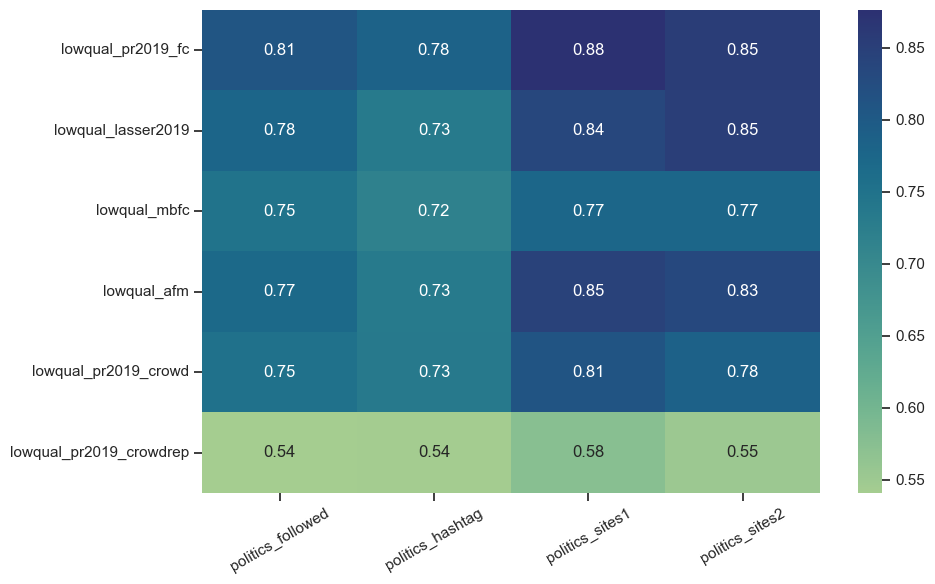

In [14]:
# Calculate pairwise correlations
correlation_data = df[group1 + group2].corr()

# Filter the correlation matrix
heatmap_data = correlation_data.loc[group1, group2]

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="crest", fmt=".2f", cbar=True)
plt.xticks(rotation=30, ha='center')
plt.tight_layout()
plt.show()

# News Sharing Can Help Explain Suspension, Using Single Predictors

*You will use the following predictors to predict whether a user was suspended or not:*

  * `politics_hashtag`
  * `politics_sites1`
  * `politics_sites2`
  * `politics_followed`
  * `lowqual_afm`
  * `lowqual_mbfc`
  * `lowqual_lasser2019`
  * `lowqual_pr2019_fc`
  * `lowqual_pr2019_crowd`

*The predictions will be with a probit model. The probit model is an alternative to logit, but while the latter uses the logit as the *link function*, the probit model uses the inverse of the cumulative distribution function (CDF) of the standard normal distribution (denoted as $\Phi^{-1}$) as the link function. Mathematically:*

$$ \Phi^{-1}(P(Y = 1 | X)) = X\beta $$

*where $P(Y = 1  | X)$ is the probability of the event occurring, $X$ represents the independent variables, and $\beta$ is the vector of coefficients.*

*The predictions will be evaluated with the AUC of the ROC curve. To get confidence intervals, repeat each prediction 100 times by using the boostrap method.*

*Print the AUC and the confidence intervals in a table. Then use them to plot all your evaluations and the confidence intervals in a barchart.*

* Creating a list of predictors.

In [15]:
predictors = [
    "politics_hashtag",
    "politics_sites1",
    "politics_sites2",
    "politics_followed",
    "lowqual_afm",
    "lowqual_mbfc",
    "lowqual_lasser2019",
    "lowqual_pr2019_fc",
    "lowqual_pr2019_crowd",
]

* Running 100 iterations for each predictor.
* Calculating summary statistics and confidence intervals.
* Storing the results.

In [16]:
bootstrap_iterations = 100
results = []

# Set the seed for reproducibility
np.random.seed(32)

for predictor in predictors:
    X = df[predictor]
    y = df['suspended']
    
    auc_scores = []

    for _ in range(bootstrap_iterations):
        # Resample
        resampled_indices = np.random.choice(df.index, size=len(df), replace=True)
        X_resampled = X.loc[resampled_indices]
        y_resampled = y.loc[resampled_indices]

        # Remove missing and infinite values
        valid_indices = X_resampled.notna() & y_resampled.notna() & np.isfinite(X_resampled) & np.isfinite(y_resampled)
        X_resampled = X_resampled[valid_indices]
        y_resampled = y_resampled[valid_indices]
        
        # Add a constant
        X_resampled = sm.add_constant(X_resampled)

        # Fit the model
        probit_model = sm.Probit(y_resampled, X_resampled).fit(disp=0)

        # Predict probabilities
        y_pred_prob = probit_model.predict(X_resampled)

        # Calculate AUC
        auc = roc_auc_score(y_resampled, y_pred_prob)
        auc_scores.append(auc)

    # Calculate summary statistics for each predictor
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores, ddof=1)
    n = len(auc_scores)

    # Calculate 95% confidence intervals
    lower_ci = np.percentile(auc_scores, 2.5)
    upper_ci = np.percentile(auc_scores, 97.5)

    # Store the results
    results.append({
        'predictor': predictor,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'lower_ci': lower_ci,
        'upper_ci': upper_ci
    })

* Printing the AUC and the confidence intervals in a table.

In [17]:
res = pd.DataFrame(results)
res[['predictor', 'mean_auc', 'lower_ci', 'upper_ci']]

,predictor,mean_auc,lower_ci,upper_ci
0,politics_hashtag,0.679713,0.666638,0.691934
1,politics_sites1,0.701596,0.686162,0.715109
2,politics_sites2,0.703636,0.690610,0.716987
3,politics_followed,0.715988,0.696922,0.733759
4,lowqual_afm,0.715336,0.701723,0.733655
5,lowqual_mbfc,0.706282,0.693132,0.721957
6,lowqual_lasser2019,0.705821,0.693792,0.720096
7,lowqual_pr2019_fc,0.698085,0.685536,0.712220
8,lowqual_pr2019_crowd,0.685185,0.669533,0.697443


* Plotting the barchart.

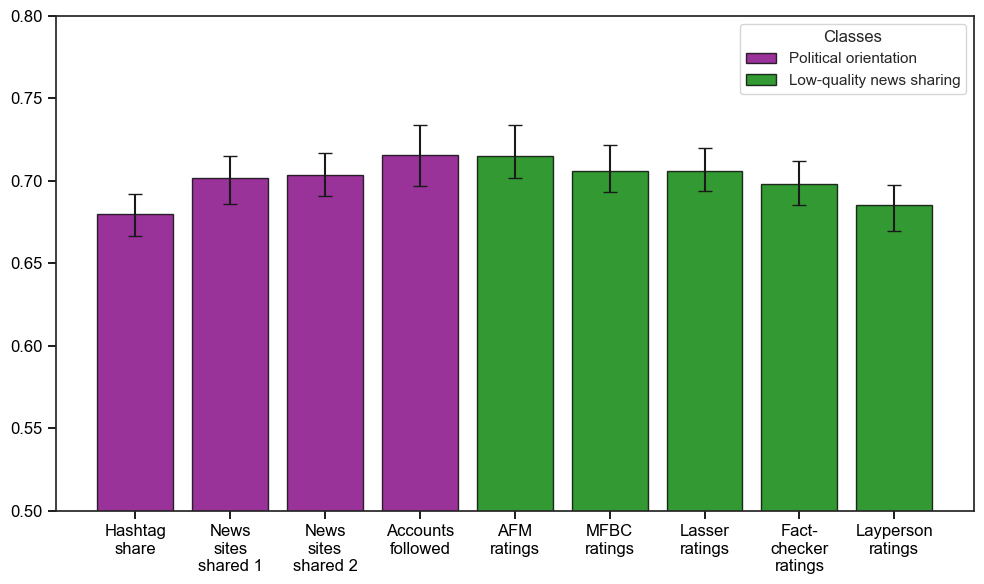

In [18]:
# Set x-axis labels
custom_labels = [
    "Hashtag share", 
    "News sites shared 1", 
    "News sites shared 2", 
    "Accounts followed", 
    "AFM ratings", 
    "MFBC ratings", 
    "Lasser ratings", 
    "Fact-checker ratings", 
    "Layperson ratings"
]

# Wrap x-axis labels
wrapped_labels = [textwrap.fill(label, width=9) for label in custom_labels]

# Set the bar colors
bar_colors = ['purple'] * 4 + ['green'] * 5

# Label the categories
category_labels = ['Political orientation', 'Low-quality news sharing']

# Plot the barchart
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bars for each predictor and assign their colors
bars = []
for i, result in enumerate(results):
    color = bar_colors[i]
    bar = ax.bar(result['predictor'], result['mean_auc'], 
                yerr=[[result['mean_auc'] - result['lower_ci']], [result['upper_ci'] - result['mean_auc']]], 
                capsize=5, color=color, label=result['predictor'], alpha=0.8, edgecolor='black')
    bars.append(bar)

# Set the x-axis labels
ax.set_xticks(range(len(results)))
ax.set_xticklabels(wrapped_labels, ha="center")

# Create the legend
handles, labels = ax.get_legend_handles_labels()
purple_bars = [bar for bar, color in zip(bars, bar_colors) if color == 'purple']
green_bars = [bar for bar, color in zip(bars, bar_colors) if color == 'green']
ax.legend([purple_bars[0], green_bars[0]], category_labels, loc='upper right', title='Classes')

# Set the size and color of the tick labels
ax.tick_params(axis='both', labelsize=12, colors='black')

# Plot the barchart
ax.set_ylim(0.5, 0.8)
plt.tight_layout()
plt.show()

# News Sharing Can Help Explain Suspension, Using Multiple Predictors

*You will also use multiple regression models to predict and explain suspension.*

*Start by filing in missing values in your data by using the column mean. Then log transform, base 10, the variables that are related to Tweeter metrics, i.e.:*

* `repeated_tweet_count` to `log_repeated_tweet_count`
* `freq_pr_1h` (maximum frequency of primary tweets in an hour) to `log_freq_pr_1h`
* `num_followers` to `log_num_followers`
* `num_friends` to `log_num_friends`

*Introduce an additional variable, `log_fol`, which should the be base 10 logarithm of `num_friends` over `num_followers` ratio. To prevent out of domain errors, add 1 to each variable when using it in the transforms.*

* Identifying the numeric columns and filling all their NaN values with each column's mean.

In [19]:
numeric_columns = df.select_dtypes(include=['number'])
df[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.mean())

* Defining the columns that need to be transformed and their transformed column names.
* Transforming them.

In [20]:
columns_to_transform = {
    'repeated_tweet_count': 'log_repeated_tweet_count',
    'freq_pr_1h': 'log_freq_pr_1h',
    'num_followers': 'log_num_followers',
    'num_friends': 'log_num_friends'
}

for original_col, new_col in columns_to_transform.items():
    df[new_col] = np.log10(df[original_col] + 1)

* Creating the 'log_fol' variable.

In [21]:
df['log_fol'] = np.log10((df['num_friends'] / df['num_followers']) + 1)

*To reduce the effect of outliers, you will [winsorize](https://en.wikipedia.org/wiki/Winsorizing) the data. Winzorize from both sides at the top 1% the following variables:*

* `valence_neg`
* `valence_neu`
* `valence_pos`
* `barbera_std`
* `politics_sites1_std`
* `politics_sites2_ideo_std`

*The `valence_*`, variables were calculated using VADER (<https://doi.org/10.1609/icwsm.v8i1.14550>). The `barbera_std` variable was calculated based on the work of Barbera et al. (<https://doi.org/10.1177/0956797615594620>).*

* Defining the variables that need winsorizing.

In [22]:
variables_to_winsorize = [
    'valence_neg',
    'valence_neu',
    'valence_pos',
    'barbera_std',
    'politics_sites1_std',
    'politics_sites2_ideo_std'
]

* Winsorizing the variables.

In [23]:
for var in variables_to_winsorize:
    df[var] = winsorize(df[var], limits=[0.01, 0.01])

*Winsorize the upper side of the following variables at the top 1%:*

* `moral_outrage`
* `rewire_abuse`
* `rewire_hate`
* `rewire_profanity`
* `rewire_violent`
* `rewire_sexually_explicit`
* `jigsaw_toxicity`
* `jigsaw_severe_toxicity`
* `jigsaw_idenity_attack`
* `jigsaw_insult`
* `jigsaw_profanity`
* `jigsaw_threat`

*The `moral_outrage` variable was calculated based on the work of Brady et al. (<https://doi.org/doi:10.1126/sciadv.abe5641>). The `rewire_*` variables were calculated using the Rewire Online API (acquired by ActiveFence in 2023)., The `jigsaw_*` variables were calculated using the Google Jigsaw Perspective API (<https://jigsaw.google.com/>, <https://perspectiveapi.com/>).*

* Defining the variables that need winsorizing.

In [24]:
variables_to_winsorize_upper = [
    'moral_outrage',
    'rewire_abuse',
    'rewire_hate',
    'rewire_profanity',
    'rewire_violent',
    'rewire_sexually_explicit',
    'jigsaw_toxicity',
    'jigsaw_severe_toxicity',
    'jigsaw_idenity_attack',
    'jigsaw_insult',
    'jigsaw_profanity',
    'jigsaw_threat'
]

* Winsorizing the variables.

In [25]:
for var in variables_to_winsorize_upper:
    df[var] = winsorize(df[var], limits=[0, 0.01])

*You will derive and use a single PCA component, `pc1_misinfo`, for low quality news sharing, that is, the variables:*

* `lowqual_pr2019_fc`
* `lowqual_afm`
* `lowqual_lasser2019`
* `lowqual_mbfc`

*Show the explained variance ratio. Then project the low quality news sharing dimensions to this new dimension.*

* Defining the PCA variables.

In [26]:
pca_variables = [
    'lowqual_pr2019_fc',
    'lowqual_afm',
    'lowqual_lasser2019',
    'lowqual_mbfc'
]

* Standardizing the PCA variables.

In [27]:
standardized_data = scaler.fit_transform(df[pca_variables])

* Performing PCA with one component.

In [28]:
pca = PCA(n_components=1)
pc1_misinfo = pca.fit_transform(standardized_data)

* Printing the explained variance ratio.

In [29]:
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio for pc1_misinfo: {explained_variance_ratio[0]}")

Explained variance ratio for pc1_misinfo: 0.8725595303656107


* Projecting the low quality news sharing dimensions to this new dimension and adding that to the df.

In [30]:
df['pc1_misinfo'] = pca.transform(standardized_data)

*We will work in the same way for the political orientation, getting a single PCA component, `pc1_politics`, for the variables:*

* `politics_hashtag`
* `politics_followed`
* `politics_sites1`
* `politics_sites2`

*Show the explained variance ratio and project the political orientation dimensions to this new dimension.*

* Defining the PCA variables.

In [31]:
pca_variables = [
    'politics_hashtag',
    'politics_followed',
    'politics_sites1',
    'politics_sites2'
]

* Standardizing the PCA variables.

In [32]:
standardized_data = scaler.fit_transform(df[pca_variables])

* Performing PCA with one component.

In [33]:
pca = PCA(n_components=1)
pc1_politics = pca.fit_transform(standardized_data)

* Printing the explained variance ratio.

In [34]:
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio for pc1_politics: {explained_variance_ratio[0]}")

Explained variance ratio for pc1_politics: 0.8795293696695505


* Projecting the political orientations dimensions to this new dimension and adding that to the df.

In [35]:
df['pc1_politics'] = pca.transform(standardized_data)

*Introduce a new variable, `extremity`, which is the absolute value of the PCA component you got.*

* Creating 'extremity'.

In [36]:
df['extremity'] = np.abs(df['pc1_politics'])

*Also do the same for `log_num_followers`, `log_num_friends`, `log_fol`, producing `pc1_fol`.*

* Defining the PCA variables.

In [37]:
pca_variables = [
    'log_num_followers',
    'log_num_friends',
    'log_fol'
]

* Checking for inf values in the PCA variables and replacing them with the column's mean.

In [38]:
df[pca_variables] = df[pca_variables].replace([np.inf, -np.inf], np.nan)
df[pca_variables] = df[pca_variables].fillna(df[pca_variables].mean())

* Standardizing the PCA variables.

In [39]:
standardized_data = scaler.fit_transform(df[pca_variables])

* Performing PCA with one component.

In [40]:
pca = PCA(n_components=1)
pc1_fol = pca.fit_transform(standardized_data)

* Printing the explained variance ratio.

In [41]:
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio for pc1_fol: {explained_variance_ratio[0]}")

Explained variance ratio for pc1_fol: 0.7287710876575256


* Projecting the dimensions to this new dimension and adding that to the df.

In [42]:
df['pc1_fol'] = pca.transform(standardized_data)

*Regarding the harmful language variables, perform PCA for *three* components, `pc1_harmful_language`, `pc2_harmful_language`, `pc3_harmful_language`, on the winsorized data of:*

* `rewire_abuse`
* `rewire_hate`
* `rewire_profanity`
* `rewire_violent`
* `rewire_sexually_explicit`
* `jigsaw_toxicity`
* `jigsaw_severe_toxicity`
* `jigsaw_idenity_attack`
* `jigsaw_insult`
* `jigsaw_profanity`
* `jigsaw_threat`

* Defining the PCA variables.

In [43]:
pca_variables = [
    'rewire_abuse',
    'rewire_hate',
    'rewire_profanity',
    'rewire_violent',
    'rewire_sexually_explicit',
    'jigsaw_toxicity',
    'jigsaw_severe_toxicity',
    'jigsaw_idenity_attack',
    'jigsaw_insult',
    'jigsaw_profanity',
    'jigsaw_threat'
]

* Standardizing the PCA variables.

In [44]:
standardized_data = scaler.fit_transform(df[pca_variables])

* Performing PCA with three components.

In [45]:
pca = PCA(n_components=3)
pcs = pca.fit_transform(standardized_data)

* Adding the new PCA components to the df.
* Printing the explained variance ratios.

In [46]:
df['pc1_harmful_language'] = pcs[:, 0]
df['pc2_harmful_language'] = pcs[:, 1]
df['pc3_harmful_language'] = pcs[:, 2]

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratios for harmful language PCA components: {explained_variance_ratio}")
print(f"Total explained variance ratio for harmful language PCA components: {explained_variance_ratio.sum()}")

Explained variance ratios for harmful language PCA components: [0.5616608  0.11871792 0.10703707]
Total explained variance ratio for harmful language PCA components: 0.7874157847381195


*Why use three components instead of one in this case? Try to interpret each of the principal components.*

* Using a function to create radar charts.

In [47]:
def radar_factory(categories, values, axes=None, fontsize=12):
    num_categories = len(categories)

    angles = [n / float(num_categories) * 2 * pi for n in range(num_categories)]
    angles += angles[:1]

    values += values[:1]

    if axes is None:
        fig, ax = plt.subplots(subplot_kw={'polar': True})
    else:
        ax = axes

    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=fontsize)
    ax.set_ylim(0, max(values) * 1.2)

    return ax

* Creating one radar chart for every PCA variable with contributions from each PCA component.

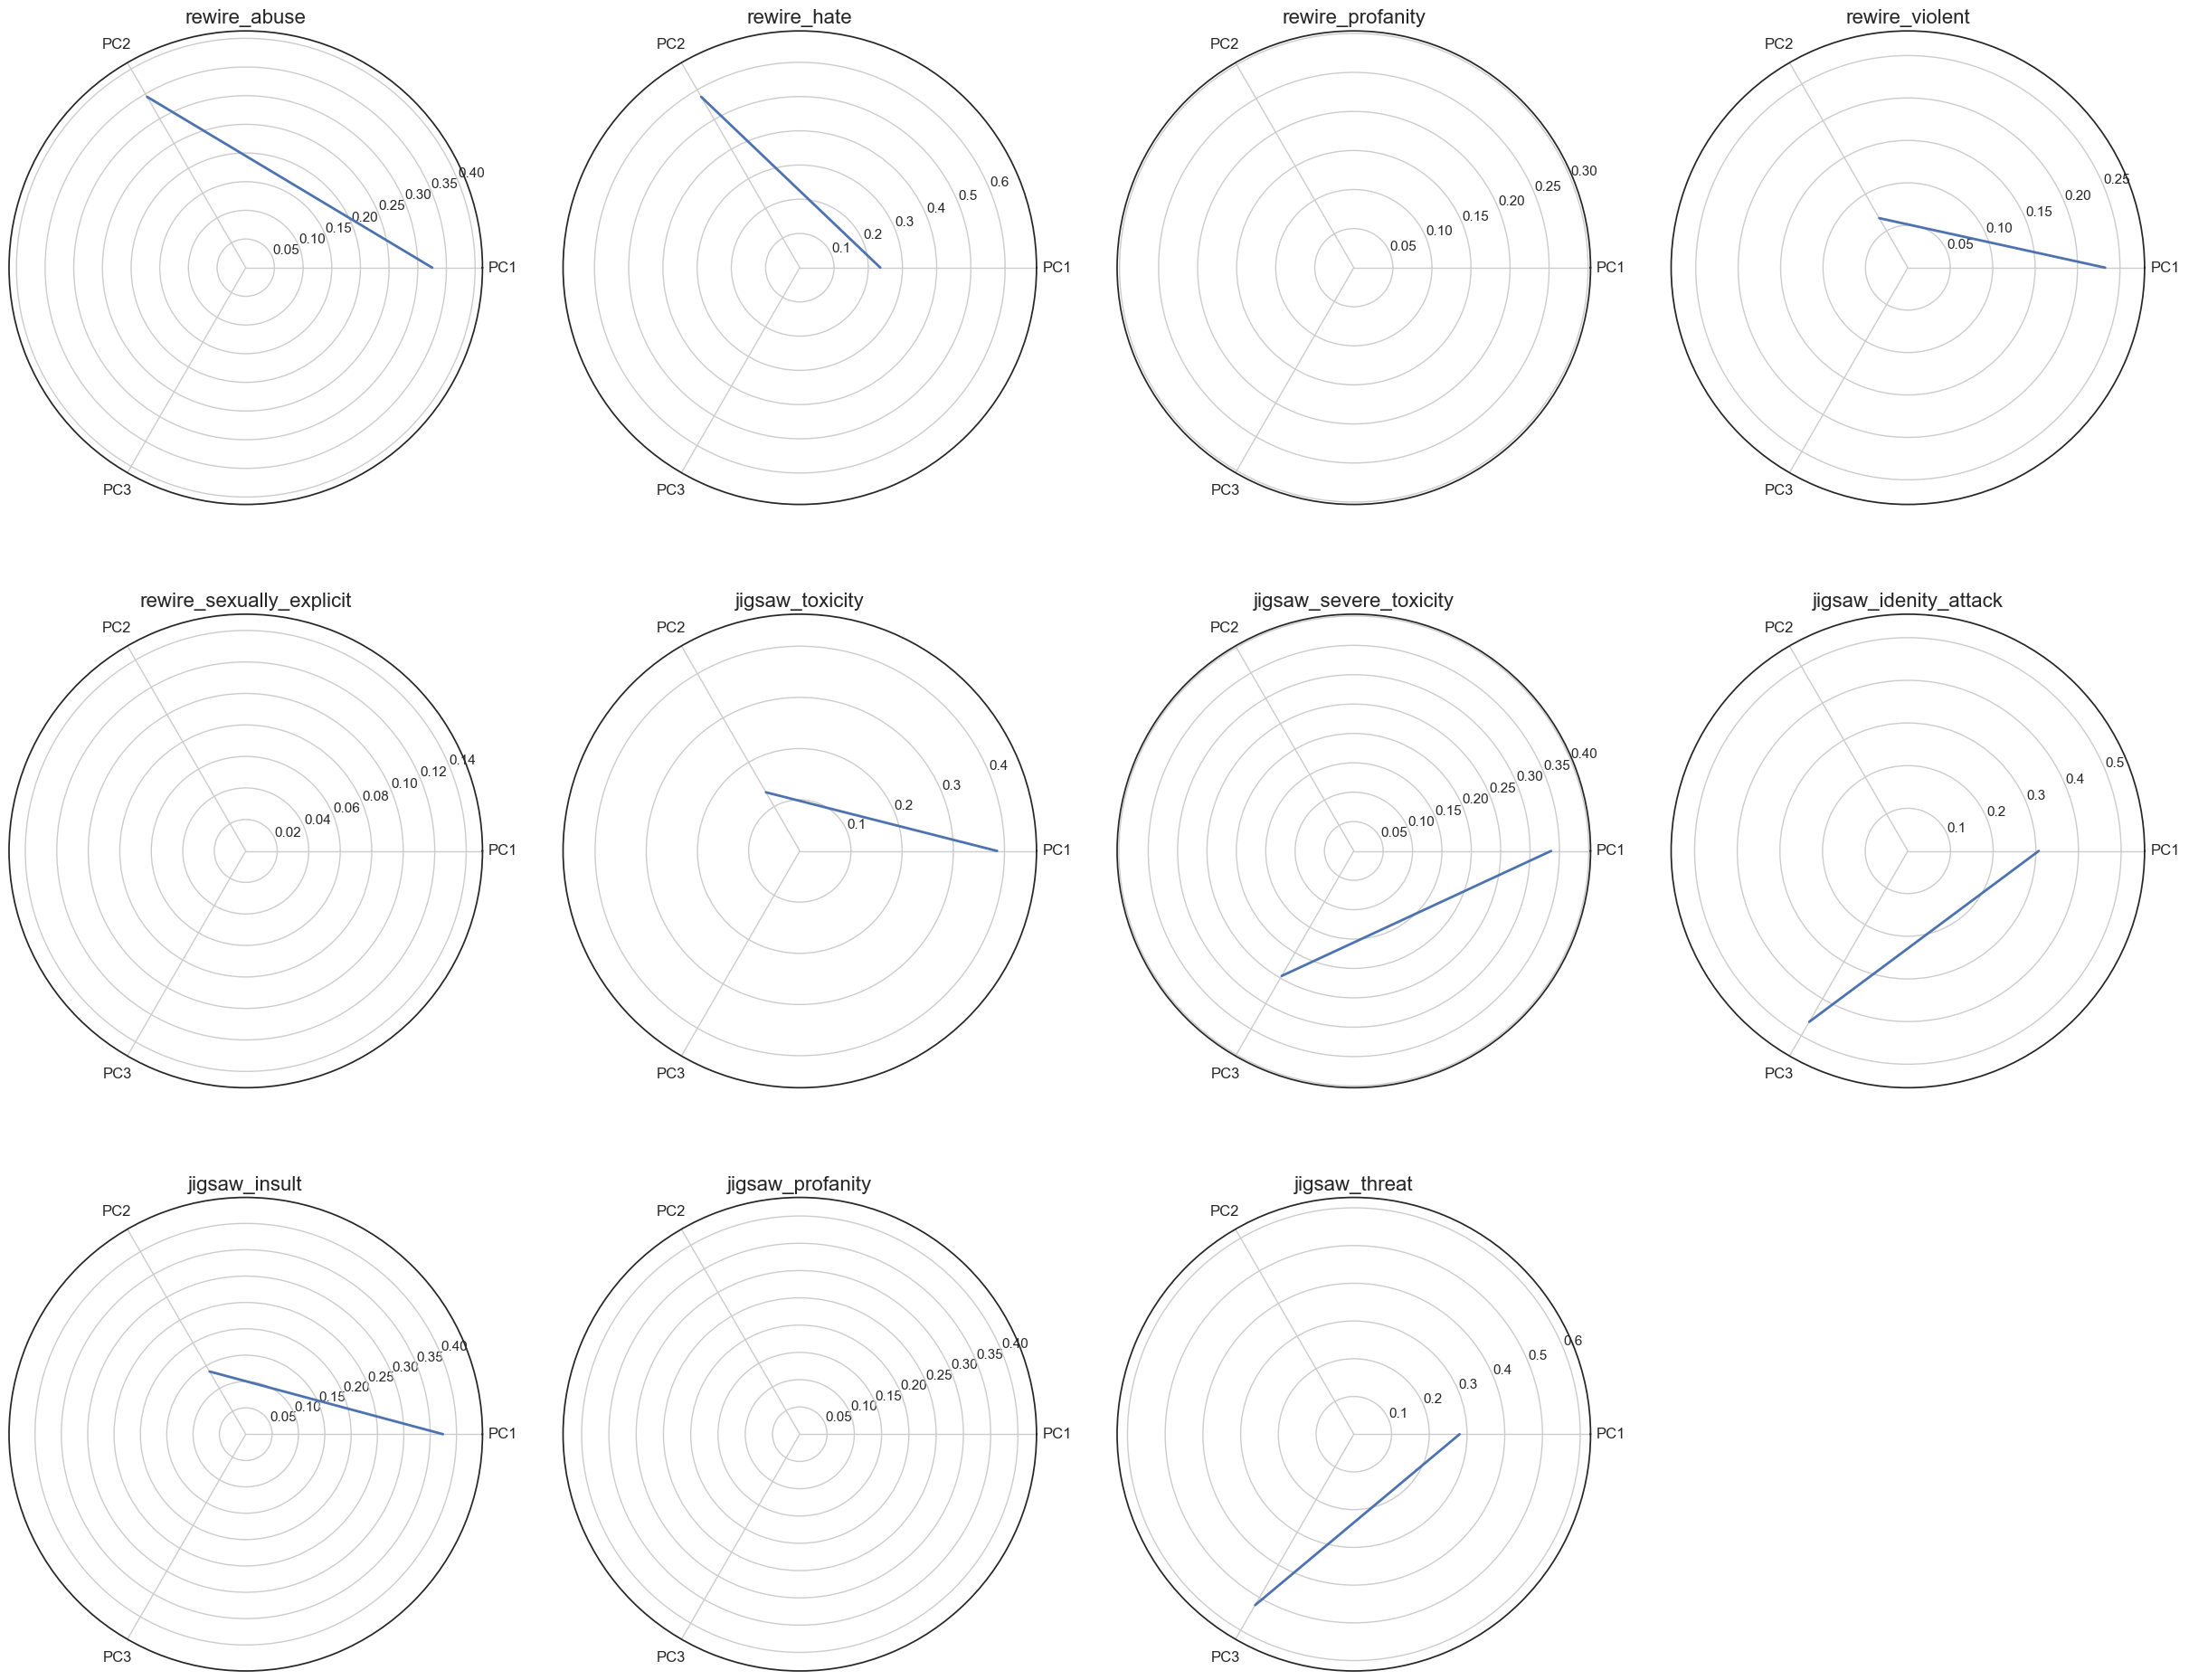

In [48]:
# Check how many components PCA actually generated
n_components = pca.components_.shape[0]

plt.figure(figsize=(25, 20))

# Loop through PCA variables
for i, variable in enumerate(pca_variables):
    ax = plt.subplot(3, 4, i + 1, polar=True)
    
    # Set available components
    components_to_plot = min(n_components, 3)
    
    # Calculate the contribution of each PCA component
    values = []
    for j in range(components_to_plot):
        values.append(pca.components_[j, i])
    
    # Plot the radar chart with the contributions of the available PCA components
    radar_factory(['PC1', 'PC2', 'PC3'][:components_to_plot], values, fontsize=12, axes=ax)
    ax.set_title(f"{variable}", fontsize=16)

plt.tight_layout(pad=3.0)
plt.show()

* The 1st PCA component only manages to explain 56.17% of information. By using multiple components, the PCA is able to explain 78.74% of information so an additional 22.57% is explained.
* Also, some differences are visible in the radar charts above.
* The 1st PCA component is mainly needed to explain "rewire_violent", "jigsaw_toxicity" and "jigsaw_insult".
* The 2nd PCA component is mainly needed to explain "rewire_abuse" and "rewire_hate".
* The 3rd PCA component is mainly needed to explain "jigsaw_identity_attack" and "jigsaw_threat".
* The 1st and 2nd PCA components are almost equally needed to explain "rewire_abuse", while the 1st and the 3rd are almost equally needed to explain "jigsaw_severe_toxicity".
* Consequently, it is obvious that each CPA component is needed to explain different parts of information.

*Return to producing a single PCA component, `pc1_valence`, for the winsorized data of the valence variables:*

* `valence_neg`
* `valence_neu`
* `valence_pos`

* Defining the PCA variables.

In [49]:
pca_variables = ['valence_neg', 
                 'valence_neu', 
                 'valence_pos']

* Standardizing the PCA variables.

In [50]:
standardized_data = scaler.fit_transform(df[pca_variables])

* Performing PCA with one component.

In [51]:
pca = PCA(n_components=1)
pc1_valence = pca.fit_transform(standardized_data)

* Adding the new PCA component to the df.
* Printing the explained variance ratio.

In [52]:
df['pc1_valence'] = pc1_valence

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio for pc1_valence: {explained_variance_ratio[0]}")

Explained variance ratio for pc1_valence: 0.7079432048725169


*Before proceeding, normalize the independent variables by taking their z-scores. You will use the following z-scored independent variables (winsorized as stated above):*

* `pc1_politics`
* `pc1_misinfo`
* `pc1_fol`
* `pc1_harmful_language`
* `pc2_harmful_language`
* `pc3_harmful_language`
* `pc1_valence`
* `tweets_in_2wk`
* `botsentinel_score`
* `extremity`
* `moral_outrage`
* `liwc_political`
* `log_freq_pr_1h`
* `log_repeated_tweet_count`
* `barbera_std`
* `politics_sites1_std`
* `politics_sites2_ideo_std`

*Carry out a probit regression to predict suspension.*

* Defining the independent variables.

In [53]:
independent_vars = [
    'pc1_politics', 'pc1_misinfo', 'pc1_fol', 'pc1_harmful_language', 
    'pc2_harmful_language', 'pc3_harmful_language', 'pc1_valence', 
    'tweets_in_2wk', 'botsentinel_score', 'extremity', 'moral_outrage', 
    'liwc_political', 'log_freq_pr_1h', 'log_repeated_tweet_count', 
    'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std'
]

* Standardizing the independent variables.

In [54]:
df[independent_vars] = scaler.fit_transform(df[independent_vars])

* Setting the list of independent variables X and the dependent variable y.

In [55]:
X = df[independent_vars]
y = df['suspended']

* Adding a constant to the dependent variable.

In [56]:
X = sm.add_constant(X)

* Fitting the probit model.

In [57]:
probit_model = sm.Probit(y, X)
probit_result = probit_model.fit()

Optimization terminated successfully.
         Current function value: 0.302637
         Iterations 7


* Displaying the probit results.

In [58]:
probit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              suspended   No. Observations:                 9000
Model:                         Probit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                  0.1762
Time:                        12:20:40   Log-Likelihood:                -2723.7
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                3.885e-237
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.4273      0.023    -61.086      0.000      -1.473      -1.381
pc1_politics                 0.1341      0.053      2.533      0.011       0.030       0.238
pc1_misinfo                  0.2450      0.047      5.267      0.000       0.154       0.336
pc1_fol                      0.0002      0.021      0.012      0.990      -0.041       0.041
pc1_harmful_language         0.1761      0.026      6.748      0.000       0.125       0.227
pc2_harmful_language        -0.0830      0.026     -3.228      0.001      -0.133      -0.033
pc3_harmful_language        -0.0662      0.021     -3.217      0.001      -0.107      -0.026
pc1_valence                  0.0409      0.023      1.817      0.069      -0.003       0.085
tweets_in_2wk                0.3318      0.021     15.963      0.000       0.291       0.373
botsentinel_score            0.1823      0.039      4.721      0.000       0.107       0.258
extremity                   -0.1198      0.023     -5.288      0.000      -0.164      -0.075
moral_outrage                0.0170      0.034      0.502      0.615      -0.049       0.083
liwc_political              -0.0227      0.029     -0.794      0.427      -0.079       0.033
log_freq_pr_1h               0.1223      0.023      5.354      0.000       0.078       0.167
log_repeated_tweet_count    -0.0074      0.023     -0.323      0.747      -0.052       0.037
barbera_std                 -0.0303      0.024     -1.276      0.202      -0.077       0.016
politics_sites1_std         -0.0258      0.021     -1.219      0.223      -0.067       0.016
politics_sites2_ideo_std     0.0612      0.022      2.753      0.006       0.018       0.105
============================================================================================
"""

*Before going on to interpret your results, perform the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) and the [Holm-Bonferroni correction](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method) correction. The purpose of both of these tests is to reduce the likelihood of false positives (Type I errors) when conducting multiple statistical tests.*

*In the Bonferroni correction, a hypothesis is rejected with an ajustment to the significance level $\alpha$:*

$$ p < \frac{\alpha}{m} $$

*which means that the $p$ values are adjusted by:*

$$ p' = p \times m $$

*where $m$ is the number of tests.*

*The Bonferroni-Holm method is less conservative compared to Bonferroni. It sorts the $p$-values in ascending order and compares them to less stringent thresholds:*

$$ p_i \le \frac{\alpha}{m - i + 1} $$ 

*where $i$ is the $i$-th smallest $p$-value. Starting with the smallest $p$-value, hypotheses are rejected sequentially until a $p$-value fails to meet the threshold. That means that the $p$ values are adjusted by:*

$$ \widetilde{p}_{(i)}=\max _{j\leq i}\left\{(m-j+1)p_{(j)}\right\}_{1}, \text{ where }p_{(j)}\text{ is the $j$-th smallest $p$-value and }\{x\}_{1}\equiv \min(x,1). $$

*Holm-Bonferroni applies progressively smaller corrections as it moves through the sorted $p$-values, making it less conservative and less likely to fall into false negatives (Type II errors).*

* Extracting all p-values from the probit results.

In [59]:
p_values = probit_result.pvalues[1:]

* Setting the number of independent variables.

In [60]:
n_tests = len(p_values)

* Performing the Bonferroni Correction.

In [61]:
bonferroni_pvalues = np.minimum(p_values * n_tests, 1)

* Performing the Holm-Bonferroni Correction.

In [62]:
# Sort the p-values in ascending order
sorted_pvalues = np.sort(p_values)
sorted_indices = np.argsort(p_values)

# Perform the Holm-Bonferroni correction
holm_pvalues = np.minimum(sorted_pvalues * (n_tests - np.arange(n_tests)), 1)

# Reorder the new p-values to match the original order
holm_pvalues_corrected = np.zeros_like(holm_pvalues)
holm_pvalues_corrected[sorted_indices] = holm_pvalues

* Creating a DataFrame to display the results.
* Displaying all p-values.

In [63]:
results_df = pd.DataFrame({
    'p-value': p_values,
    'Bonferroni Corrected p-value': bonferroni_pvalues,
    'Holm-Bonferroni Corrected p-value': holm_pvalues_corrected
})

results_df

,p-value,Bonferroni Corrected p-value,Holm-Bonferroni Corrected p-value
pc1_politics,1.130754e-02,1.922281e-01,9.046029e-02
pc1_misinfo,1.387620e-07,2.358955e-06,1.803907e-06
pc1_fol,9.904612e-01,1.000000e+00,9.904612e-01
pc1_harmful_language,1.503655e-11,2.556213e-10,2.405847e-10
pc2_harmful_language,1.244948e-03,2.116411e-02,1.369442e-02
pc3_harmful_language,1.296756e-03,2.204486e-02,1.296756e-02
pc1_valence,6.927559e-02,1.000000e+00,4.849292e-01
tweets_in_2wk,2.327300e-57,3.956410e-56,3.956410e-56
botsentinel_score,2.349708e-06,3.994504e-05,2.819650e-05
extremity,1.234522e-07,2.098687e-06,1.728330e-06


*Based on the results, do you think that political orientation influences suspension?*

* The influence of political orientation can be derived from the significance of the variables 'pc1_politics', 'politics_sites1_std' and 'politics_sites2_ideo_std'.
* Concerning 'pc1_politics', both Bonferroni and Holm-Bonferroni p-values (0.1922, 0.0905) are not significant at the a=0.05, while the p-value derived from the probit model (0.0113) is statistically significant.
* Concerning 'politics_sites1_std', all p-values (0.2230, 1.0000, 1.0000) are not significant at the a=0.05.
* Concerning 'politics_sites2_ideo_std', Bonferroni p-value (0.1004) is not significant at the a=0.05, as well as Holm-Bonferroni p-value (0.0531) which is marginally not significant. In contrast, the p-value derived from the probit model (0.0059) is statistically significant.
* Consequently, the p-values derived from the probit model suggest that some political orientation variables influence suspension, specifically 'pc1_politics' and 'politics_sites2_ideo_std'.
* After applying the Bonferroni and Holm-Bonferroni corrections, however, all political orientation variables, except for politics_sites2_ideo_std under Holm-Bonferroni that is borderline significant, do not remain statistically significant.
* Overall, while there is a hint of a potential relationship between political orientation and suspension, the corrected p-values prove that the influence is not robust enough to state that political orientation influences suspension.

*Do the same analysis using logit regression.*

* The independent variables have already been defined and standardized.
* The independent and dependent variables have already been set.
* The constant has been added to the dependent variable.
* So the analysis picks up from there.

* Fitting the logit model.

In [64]:
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.303039
         Iterations 7


* Displaying the logit results.

In [65]:
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              suspended   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                  0.1751
Time:                        12:20:40   Log-Likelihood:                -2727.4
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                1.381e-235
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.5393      0.049    -51.799      0.000      -2.635      -2.443
pc1_politics                 0.2688      0.100      2.677      0.007       0.072       0.466
pc1_misinfo                  0.4698      0.087      5.428      0.000       0.300       0.639
pc1_fol                     -0.0009      0.039     -0.022      0.982      -0.077       0.075
pc1_harmful_language         0.3049      0.048      6.390      0.000       0.211       0.398
pc2_harmful_language        -0.1469      0.047     -3.150      0.002      -0.238      -0.055
pc3_harmful_language        -0.1163      0.037     -3.163      0.002      -0.188      -0.044
pc1_valence                  0.0699      0.041      1.697      0.090      -0.011       0.151
tweets_in_2wk                0.6140      0.038     16.236      0.000       0.540       0.688
botsentinel_score            0.3497      0.071      4.945      0.000       0.211       0.488
extremity                   -0.2454      0.042     -5.841      0.000      -0.328      -0.163
moral_outrage                0.0438      0.063      0.699      0.485      -0.079       0.167
liwc_political              -0.0597      0.053     -1.129      0.259      -0.163       0.044
log_freq_pr_1h               0.2125      0.042      5.025      0.000       0.130       0.295
log_repeated_tweet_count    -0.0176      0.042     -0.417      0.677      -0.100       0.065
barbera_std                 -0.0592      0.043     -1.372      0.170      -0.144       0.025
politics_sites1_std         -0.0506      0.039     -1.286      0.199      -0.128       0.027
politics_sites2_ideo_std     0.1064      0.041      2.603      0.009       0.026       0.187
============================================================================================
"""

* Extracting all p-values from the logit results.

In [66]:
p_values = logit_result.pvalues[1:]

* Setting the number of independent variables.

In [67]:
n_tests = len(p_values)

* Performing the Bonferroni Correction.

In [68]:
bonferroni_pvalues = np.minimum(p_values * n_tests, 1)

* Performing the Holm-Bonferroni Correction.

In [69]:
# Sort the p-values in ascending order
sorted_pvalues = np.sort(p_values)
sorted_indices = np.argsort(p_values)

# Perform the Holm-Bonferroni correction
holm_pvalues = np.minimum(sorted_pvalues * (n_tests - np.arange(n_tests)), 1)

# Reorder the new p-values to match the original order
holm_pvalues_corrected = np.zeros_like(holm_pvalues)
holm_pvalues_corrected[sorted_indices] = holm_pvalues

* Creating a DataFrame to display the results.
* Displaying all p-values.

In [70]:
logit_results_df = pd.DataFrame({
    'p-value': p_values,
    'Bonferroni Corrected p-value': bonferroni_pvalues,
    'Holm-Bonferroni Corrected p-value': holm_pvalues_corrected
})

logit_results_df

,p-value,Bonferroni Corrected p-value,Holm-Bonferroni Corrected p-value
pc1_politics,7.430038e-03,1.263107e-01,6.687034e-02
pc1_misinfo,5.711570e-08,9.709669e-07,7.996198e-07
pc1_fol,9.821560e-01,1.000000e+00,9.821560e-01
pc1_harmful_language,1.661730e-10,2.824940e-09,2.658767e-09
pc2_harmful_language,1.634269e-03,2.778257e-02,1.634269e-02
pc3_harmful_language,1.562930e-03,2.656981e-02,1.719223e-02
pc1_valence,8.975063e-02,1.000000e+00,6.282544e-01
tweets_in_2wk,2.813870e-59,4.783579e-58,4.783579e-58
botsentinel_score,7.633574e-07,1.297708e-05,9.160289e-06
extremity,5.185607e-09,8.815532e-08,7.778410e-08


* Elaborating on whether political orientation influences suspension based on the logit model results.

* The influence of political orientation can be derived from the significance of the variables 'pc1_politics', 'politics_sites1_std' and 'politics_sites2_ideo_std'.
* Concerning 'pc1_politics', both Bonferroni and Holm-Bonferroni p-values (0.1236, 0.06687) are not significant at the a=0.05, while the p-value derived from the logit model (0.0074) is statistically significant.
* Concerning 'politics_sites1_std', all p-values (0.1986, 1.0000, 1.0000) are not significant at the a=0.05.
* Concerning 'politics_sites2_ideo_std', both Bonferroni and Holm-Bonferroni p-values (0.1571, 0.0739) are not significant at the a=0.05, while the p-value derived from the logit model (0.0092) is statistically significant.
* Consequently, the p-values derived from the logit model suggest that some political orientation variables influence suspension, specifically 'pc1_politics' and 'politics_sites2_ideo_std'.
* After applying the Bonferroni and Holm-Bonferroni corrections, however, all political orientation variables do not remain statistically significant.
* Overall, while there is a hint of a potential relationship between political orientation and suspension, the corrected p-values prove that the influence is not robust enough to state that political orientation influences suspension.
* Consequently, the results of both the probit and the logit models lead to the same conclusion.